In [1]:
import pandas
from textwrap import wrap
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [2]:
import os
import sys
import json
from langchain.schema import Document
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.text_splitter import CharacterTextSplitter
from langchain.prompts.prompt import PromptTemplate
from langchain.chains import LLMChain

In [3]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
WATCH_DIRECTORY = os.getenv("WATCH_DIRECTORY")
OPENAI_ENGINE = os.getenv("OPENAI_ENGINE")

In [4]:
def get_pdf_paths(directory):
    """
    This function scans the specified directory and returns the file paths of all PDF files in it.
    """
    pdf_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.pdf'):
                pdf_paths.append(os.path.join(root, file))
    return pdf_paths

# Usage
directory = WATCH_DIRECTORY
pdf_paths = get_pdf_paths(directory)
print(pdf_paths)

['C:/Users/koush/Synthia_Anaconda/src/synthia/notebooks/data\\Article 39 - Exempt Officers and Sergeants Modified Duty Program.pdf', 'C:/Users/koush/Synthia_Anaconda/src/synthia/notebooks/data\\Association of Building Mechanical and Electrical Inspectors (ABMEI) MOA.pdf', 'C:/Users/koush/Synthia_Anaconda/src/synthia/notebooks/data\\Association of Engineers and Architects IFPTE Local 21 Unit 43 MOA.pdf', 'C:/Users/koush/Synthia_Anaconda/src/synthia/notebooks/data\\Association of Engineers and Architects IFTPE Local 21 Units 4142 MOA.pdf', 'C:/Users/koush/Synthia_Anaconda/src/synthia/notebooks/data\\Association of Legal Professionals of San Jose (ALP).pdf', 'C:/Users/koush/Synthia_Anaconda/src/synthia/notebooks/data\\Association of Maintenance Supervisory Personnel IFPTE Local 21 (AMSP) MOA.pdf', 'C:/Users/koush/Synthia_Anaconda/src/synthia/notebooks/data\\City Association of Management Personnel IFPTE Local 21 (CAMP) MOA.pdf', 'C:/Users/koush/Synthia_Anaconda/src/synthia/notebooks/data\

In [5]:
pages = []
def fetch_pages(pdf_paths):
    for file_path in pdf_paths:
        loader = PyPDFLoader(file_path)
        doc = loader.load()
        for page in doc:
            ind_pages = Document(page_content=page.page_content)
            pages.append(ind_pages)

In [6]:
fetch_pages(pdf_paths)

In [7]:
len(pages)

676

# Serialize and Save Object to retrieve in query_engine_modelling.ipynb

In [8]:
import pickle
documents_list = pages
with open('documents.pkl', 'wb') as file:
    pickle.dump(documents, file)


NameError: name 'documents' is not defined

In [11]:
import tiktoken
tiktoken.encoding_for_model("gpt-4")
tokenizer = tiktoken.get_encoding("cl100k_base")
def tiktoken_len(text):
    tokens = tokenizer.encode(text,disallowed_special=())
    return len(tokens)

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 400,
    chunk_overlap = 20,
    length_function = tiktoken_len,
    separators=["\n\n","\n"," ",""]
)

In [13]:
pages_chunks = text_splitter.split_documents(pages)

In [14]:
len(pages_chunks)

1579

In [16]:
def extract_page_contents(object_list):
    return [obj.page_content for obj in object_list]

pages_chunks = extract_page_contents(pages_chunks)

In [18]:
def is_useful_chunk(text,llm_object):
    llm = llm_object
    determining_template = """
    You need to determine if a piece of text is informative or non-informative elements like the headers, footers etc. and can be used to 
    generate a question and a relevant answer for the question.

    {text}

    Here are some instructions which you should follow in the process of determining if piece of text is informative and useful:
    1. Check if ample meaningful content is available for framing a question and suggesting an ideal answer

    Based on your finding, return a boolean value of True or False. If Question & Answer Pairs can be generated, return true else false.
    """
    determining_prompt = PromptTemplate(input_variables=["text"], template=determining_template)
    determining_prompt.format(text=text)
    determining_chain = LLMChain(llm=llm, prompt=determining_prompt, verbose=True)
    response = determining_chain({"text" : text})
    determining_flag = response["text"]
    return determining_flag

In [41]:
useful_text_chunks = []
llm = ChatOpenAI(temperature=0,model_name = OPENAI_ENGINE)
for chunk in pages_chunks:
    flag = is_useful_chunk(chunk,llm)
    if flag:
        useful_text_chunks.append(chunk)



> Entering new LLMChain chain...
Prompt after formatting:

    You need to determine if a piece of text is informative or non-informative elements like the headers, footers etc. and can be used to 
    generate a question and a relevant answer for the question.

    Office of Employee Relations  
Exempt Officers’ and Sergeants’ Modified Duty Program  
                                                                                           
   Original Effective Date: June 21, 2005  
Revised Effective Date:  May 11, 2020  
Page 1 of 6 
 BACKGROUND  
1. The City and San Jose Police Officers ’ Association (SJPOA) recognize that, despite best 
efforts to promote safety, police officers and sergeants are injured in the line of duty. Such 
injuries are unfortunate but can be a consequence of police work. The Exempt Officers ’ 
and Sergeants ’ Modified Duty Program (“Program ”) is available to any police officer or 
sergeant that has work -related or non -work related injuries or illnesse

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).



> Finished chain.


> Entering new LLMChain chain...
Prompt after formatting:

    You need to determine if a piece of text is informative or non-informative elements like the headers, footers etc. and can be used to 
    generate a question and a relevant answer for the question.

    beyond the control of the employee. Each employee who is granted a leave pursuant 
to the provisions of this Article shall, upon return f rom leave, be entitled to the 
position within the classification held by the employee at the time the leave 
commenced.  
 
13.3  If the position to which an employee would otherwise be entitled pursuant to the 
above has been deleted from the department's budg et during the term of the 
employee's leave of absence, the employee shall, upon return from leave, be entitled 
to a position within the classification held by the employee at the time the leave 
commenced, provided there is either a vacancy in such classifi cation or an employee 
in the classification with l

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).



> Finished chain.


> Entering new LLMChain chain...
Prompt after formatting:

    You need to determine if a piece of text is informative or non-informative elements like the headers, footers etc. and can be used to 
    generate a question and a relevant answer for the question.

    1547 Buyer I  28.23  34.33  2,258.40  2,746.40   29.08  35.36  2,326.40  2,828.80  
1542 Buyer II  33.98  41.33  2,718.40  3,306.40   35.00  42.57  2,800.00  3,405.60  
1544 Buyer III  39.35  47.93  3,148.00  3,834.40   40.53  49.37  3,242.40  3,949.60  
5116 Chemist  37.87  46.01  3,029.60  3,680.80   39.01  47.39  3,120.80  3,791.20  
5110 Chemist PT  37.87  46.01  3,029.60  3,680.80   39.01  47.39  3,120.80  3,791.20  
8057 Class Instructor PT  16.07  31.81  1,285.60  2,544.80   16.55  32.76  1,324.00  2,620.80  
3938 Code Enforcement Insp I  33.17  40.29  2,653.60  3,223.20   34.17  41.50  2,733.60  3,320.00

    Here are some instructions which you should follow in the process of determining if pie

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).



> Finished chain.


> Entering new LLMChain chain...
Prompt after formatting:

    You need to determine if a piece of text is informative or non-informative elements like the headers, footers etc. and can be used to 
    generate a question and a relevant answer for the question.

    POPRA Side Letter — Hiring Incentive and Referral Bonus 
May 24, 2023 
An individual who is newly hired shall be allowed to disclose a maximum of one (1) referral. The 
applicant must provide the referrer’s name on his or her application prior to submitting the 
application for consideration and certify that the referrer referred and/or assisted in recruiting 
them, and that the applicant will not receive any portion of the POPRA Referral Bonus provided 
to them. 
Employees involved in the recruiting and/or or hiring of new Park Rangers (2423) are not 
eligible to receive the POPRA Referral Bonus. 
The POPRA Referral Bonus shall be in lieu of the existing Citywide referral bonus of $500 per 
referral. 


In [43]:
len(useful_text_chunks)

1579

In [45]:
def write_json_lines(file_path, qa_pairs):
    with open(file_path, 'a') as f:
        for i, qa_list in enumerate(qa_pairs):
            for j, obj in enumerate(qa_list):
                f.write(json.dumps(obj, ensure_ascii=False))
                if i < len(qa_pairs) - 1 or j < len(qa_list) - 1:
                    f.write('\n')  # Write a newline if not the last object

In [50]:
def generate_questions_answers(text_chunks,llm_object):
    llm = llm_object
    qa_pairs = []
    for chunk in text_chunks:
            # Generate question using LLM
            qa_template = """

            Here's the sample content from the MOU signed between

            City of San Jose and one of the bargaining units aavailable in the City:

            {chunk}

            Follow the below instructions very seriouslly to generate each data point (Don't mess up with Array of JSON Objects Structure mentioned below, make no mistakes):

            1. Each Data point should be a JSON Object, with keys <<chat_history>>, <<question>> and <<ideal>>.

            2. Value of the <<chat_history>> should be []

            3. Value of the <<question>> should be

            the question you will be generating from the above piece of information

            provided to you.

            4. The value of the <<ideal>> key should be the answer of the question you'll be adding to

            <<content>> key in the user's object. Value should be detailed and very relevant.

            5. The value of text key you return should be should be a list of JSON Objects


            Generate a couple of JSON Lines Data Points in the following format (Don't return with new line characters.):

            [{{"chat_history":"[]","question": "The first US president was ","ideal": "George Washington"}}]

            """
            qa_prompt = PromptTemplate(input_variables=["chunk"], template=qa_template)
            qa_prompt.format(chunk=chunk)
            qa_chain = LLMChain(llm=llm, prompt=qa_prompt, verbose=True)
            response = qa_chain({"chunk" : chunk})
            response_text = response['text']
            # Split the response text into separate JSON objects
            response_lines = response_text.strip().split('\n')
            for line in response_lines:
                 try:
                     # Load each JSON object and append it to qa_pairs
                     new_qa_pairs = json.loads(line)
                     qa_pairs.append(new_qa_pairs)
                 except json.JSONDecodeError as e:
                     print("Error decoding JSON:", e)
            """
            new_qa_pairs = json.loads(response['text'])
            qa_pairs.extend(new_qa_pairs)
            """
            print(qa_pairs)
    return qa_pairs

In [1]:
text_chunks = useful_text_chunks
llm = ChatOpenAI(temperature=0,model_name = OPENAI_ENGINE)
qa_pairs = generate_questions_answers(text_chunks,llm)
# Specify the input JSON Lines File Path
val_test_file_path = 'data/train_val_test.jsonl'
write_json_lines(val_test_file_path, qa_pairs)

NameError: name 'useful_text_chunks' is not defined

In [34]:
# Define the input and output file paths
input_file_path = "data/llm1_finetuning_dataset_v2.jsonl"
output_file_path = "data/synthia_knowledge_graph_dataset.jsonl"

# Function to format a data point
def format_data(data_point):
    system_content = ""
    user_content = ""
    assistant_content = ""
    in_inst = False

    for message in data_point["messages"]:
        role = message["role"]
        content = message["content"]

        if role == "system":
            system_content = content
        elif role == "user":
            user_content = content
        elif role == "assistant":
            assistant_content = content

    formatted_text = f"<s>[INST] {system_content} Text given to you is {user_content} [/INST], {assistant_content} </s>"
    return {"text": formatted_text}

# Read input data from the JSONL file
input_data = []
with open(input_file_path, "r", encoding="utf-8") as input_file:
    for line in input_file:
        data_point = json.loads(line)
        input_data.append(data_point)

# Format the input data and store it in a list
formatted_data = [format_data(data_point) for data_point in input_data]

# Write the formatted data to the output JSONL file
with open(output_file_path, "w", encoding="utf-8") as output_file:
    for item in formatted_data:
        output_file.write(json.dumps(item, ensure_ascii=False) + "\n")

In [37]:
# Define the paths for the original and new JSONL files
original_file_path = "data/synthia_knowledge_graph_dataset.jsonl"
new_file_path = "data/synthia_knowledge_graph_dataset_v2.jsonl"

# Number of data points you want to select (in this case, 100)
num_data_points_to_select = 100

# List to store the selected data points
selected_data_points = []

# Read the original JSONL file and select the first 100 data points
with open(original_file_path, "r", encoding="utf-8") as original_file:
    for i, line in enumerate(original_file):
        if i < num_data_points_to_select:
            data_point = json.loads(line)
            selected_data_points.append(data_point)
        else:
            break

# Write the selected data points to the new JSONL file
with open(new_file_path, "w", encoding="utf-8") as new_file:
    for data_point in selected_data_points:
        new_file.write(json.dumps(data_point, ensure_ascii=False) + "\n")

print(f"Created a new JSONL dataset with {len(selected_data_points)} data points.")


Created a new JSONL dataset with 100 data points.


In [42]:
def extract_text_from_file(file_path):
    extracted_texts = []
    with open(file_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            start = data["text"].find("Text given to you is") + len("Text given to you is")
            end = data["text"].find("[/INST]")
            extracted_texts.append(data["text"][start:end].strip())
    return extracted_texts

# Example usage
file_path = 'data/synthia_knowledge_graph_dataset_v2.jsonl'
texts = extract_text_from_file(file_path)

In [43]:
texts

["Live Johnny Winter And is a 1971 album by Johnny Winter recorded live at various locations during the fall of 1970 including the Capitol Theatre in Port Chester, New York, and Pirate's World in Dania, Florida.",
 'Empedaula is a genus of moth in the family Gelechiidae.',
 'Mei Li is a book by Thomas Handforth. Released by Doubleday, it was the recipient of the Caldecott Medal for illustration in 1939.',
 '"The Awful Battle of the Pekes and the Pollicles" is a song in the musical Cats. It is sung mostly by Munkustrap. It describes a battle between two neighbouring dog tribes, the Pekes and the Pollicles, who bark "until you could hear them all over the park". The cats stage the battles by dressing up as dogs and barking in each other\'s faces. This goes on until the Great Rumpus Cat arrives and scares the dogs away.',
 'John Simon Bercow (born January 19 1963) is a politician and Conservative Party Member of Parliament for Buckingham in the United Kingdom with a current majority of 18

## Version 2

In [9]:
import json

def reformat_jsonl_data(input_file, output_file):
    """
    Reads data from a JSONL file, reformats it, and writes the reformatted data to a new JSONL file.

    Args:
    input_file (str): Path to the input JSONL file.
    output_file (str): Path to the output JSONL file.
    """
    with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8') as outfile:
        for line in infile:
            data_point = json.loads(line)
            system_prompt = user_prompt = model_answer = ""

            for message in data_point["messages"]:
                if message["role"] == "system":
                    system_prompt = message["content"]
                elif message["role"] == "user":
                    user_prompt = message["content"]
                elif message["role"] == "assistant":
                    model_answer = message["content"]

            formatted_str = f"<s>[INST] <<SYS>>{system_prompt}<</SYS>> {user_prompt} [/INST] {model_answer} </s>"
            outfile.write(json.dumps({"text": formatted_str}) + "\n")

# Example usage
input_jsonl = "data/llm1_finetuning_dataset_v2.jsonl"  # Path to your input JSONL file
output_jsonl = "data/synthia_knowledge_graph_dataset_final.jsonl"  # Path for the new output JSONL file
reformat_jsonl_data(input_jsonl, output_jsonl)

In [12]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split

# Function to read the JSONL file and return a DataFrame
def read_jsonl_to_df(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_data = json.loads(line)
            data.append(json_data)
    return pd.DataFrame(data)

# Function to split the data and write to separate files
def split_and_write_data(file_path, train_ratio, val_ratio, test_ratio, train_file_path, val_file_path, test_file_path):
    # Read data from file
    df = read_jsonl_to_df(file_path)

    # Splitting the dataset into train, validation and test sets
    train, temp = train_test_split(df, test_size=(1 - train_ratio), random_state=42)
    val, test = train_test_split(temp, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)

    # Writing the datasets to files
    train.to_json(train_file_path, orient='records', lines=True)
    val.to_json(val_file_path, orient='records', lines=True)
    test.to_json(test_file_path, orient='records', lines=True)

    return len(train), len(val), len(test)

# Example usage
file_path = 'data/synthia_knowledge_graph_dataset_final.jsonl'
train_file_path = 'data/synthia_knowledge_graph_dataset_train.jsonl'
test_file_path = 'data/synthia_knowledge_graph_dataset_test.jsonl'
val_file_path = 'data/synthia_knowledge_graph_dataset_val.jsonl'
split_and_write_data(
    file_path=file_path, 
    train_ratio=0.70, 
    val_ratio=0.10, 
    test_ratio=0.20, 
    train_file_path=train_file_path, 
    val_file_path=val_file_path, 
    test_file_path=test_file_path
)

(828, 118, 237)

In [18]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Function to read JSONL file and calculate text lengths
def get_text_lengths(file_path):
    lengths = []
    with open(file_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            text_length = len(data['text'].split()) # Length in terms of number of words
            lengths.append(text_length)
    return lengths

# Replace these with your actual file paths
train_file_path = 'data/synthia_knowledge_graph_dataset_train.jsonl'
val_file_path = 'data/synthia_knowledge_graph_dataset_val.jsonl'
test_file_path = 'data/synthia_knowledge_graph_dataset_test.jsonl'

# Get text lengths for each dataset
train_lengths = get_text_lengths(train_file_path)
val_lengths = get_text_lengths(val_file_path)
test_lengths = get_text_lengths(test_file_path)

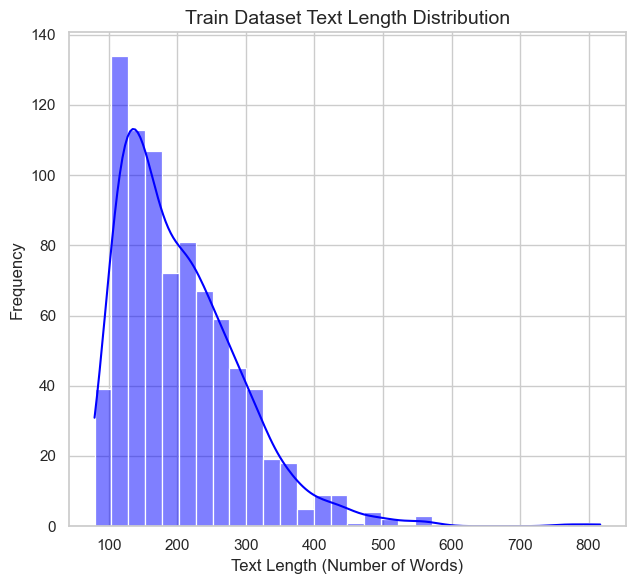

In [19]:
# Setting up Seaborn for aesthetics
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(18, 6))

# Subplot for Train Dataset
plt.subplot(1, 3, 1)
sns.histplot(train_lengths, bins=30, color='blue', kde=True)
plt.title('Train Dataset Text Length Distribution', fontsize=14)
plt.xlabel('Text Length (Number of Words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

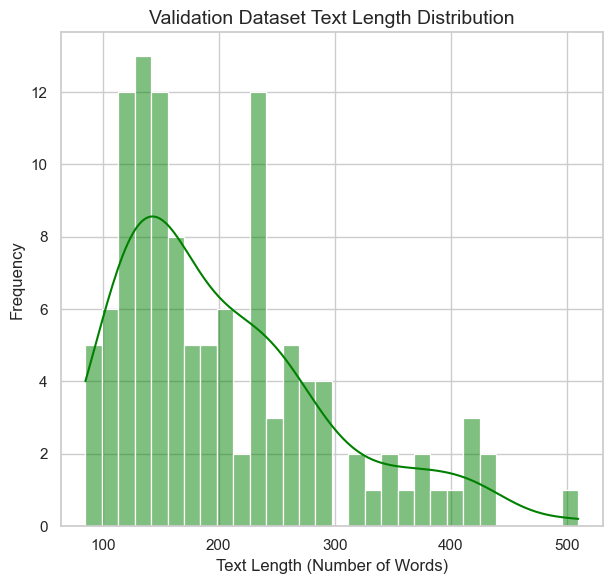

In [20]:
# Setting up Seaborn for aesthetics
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(18, 6))

# Subplot for Validation Dataset
plt.subplot(1, 3, 2)
sns.histplot(val_lengths, bins=30, color='green', kde=True)
plt.title('Validation Dataset Text Length Distribution', fontsize=14)
plt.xlabel('Text Length (Number of Words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

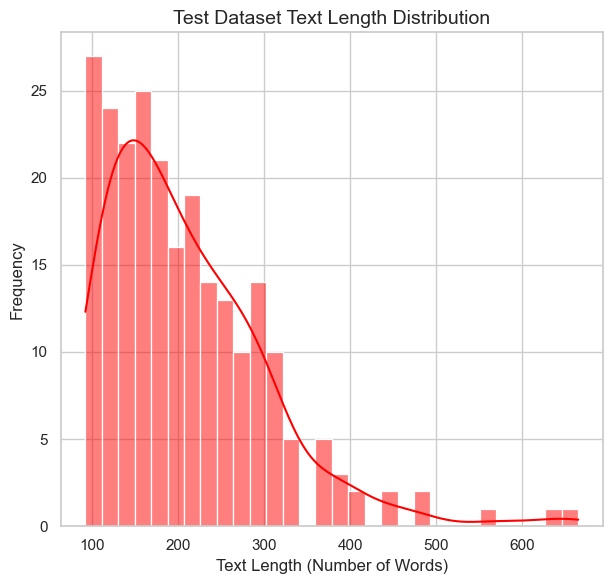

In [21]:
# Setting up Seaborn for aesthetics
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(18, 6))

# Subplot for Test Dataset
plt.subplot(1, 3, 3)
sns.histplot(test_lengths, bins=30, color='red', kde=True)
plt.title('Test Dataset Text Length Distribution', fontsize=14)
plt.xlabel('Text Length (Number of Words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

C:\Users\koush\AppData\Local\Temp\ipykernel_34440\890277477.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=datasets, y=counts, palette="viridis")


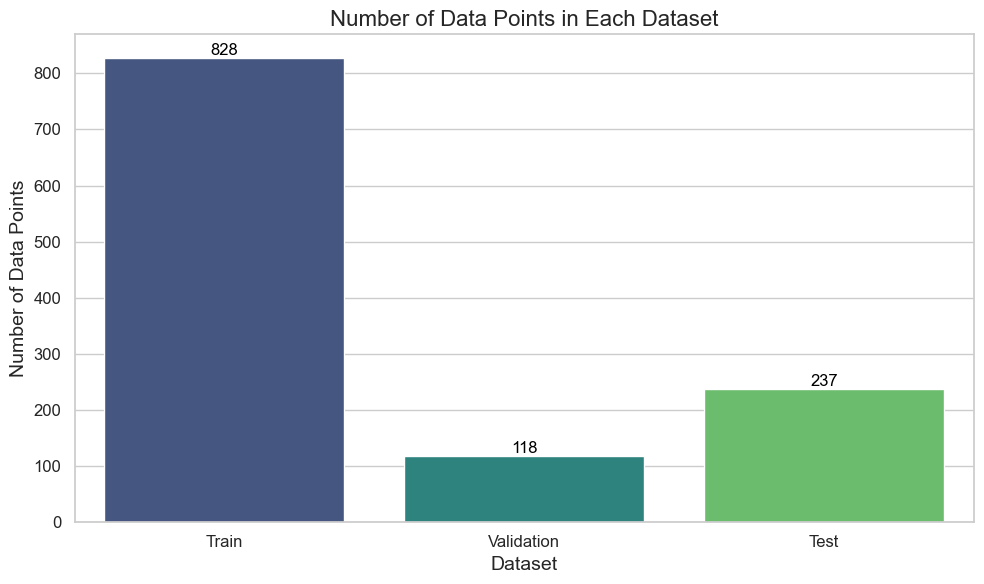

In [23]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Function to read JSONL file and count the number of data points
def count_data_points(file_path):
    count = 0
    with open(file_path, 'r') as file:
        for line in file:
            count += 1
    return count

# Replace these with your actual file paths
train_file_path = 'data/synthia_knowledge_graph_dataset_train.jsonl'
val_file_path = 'data/synthia_knowledge_graph_dataset_val.jsonl'
test_file_path = 'data/synthia_knowledge_graph_dataset_test.jsonl'

# Get counts for each dataset
train_count = count_data_points(train_file_path)
val_count = count_data_points(val_file_path)
test_count = count_data_points(test_file_path)

# Data for plotting
datasets = ['Train', 'Validation', 'Test']
counts = [train_count, val_count, test_count]

# Setting up Seaborn for aesthetics
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=datasets, y=counts, palette="viridis")
plt.title('Number of Data Points in Each Dataset', fontsize=16)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding the count above the bars
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha = 'center', va = 'bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()